[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DSIMB/PoincareMSA/blob/master/PoincareMSA_colab.ipynb)

<img src="https://github.com/DSIMB/PoincareMSA/blob/master/.github/PoincareMSA_small_logo.png?raw=true" height="100" style="height:100px;margin-left: 0px;">

# Poincaré maps for visualization of large protein famillies

**Authors**: Anna Klimovskaia Susmelj, Yani Ren, Yann Vander Meersche, Jean-Christophe Gelly and Tatiana Galochkina

PoincaréMSA builds an interactive projection of an input protein multiple sequence alignemnt (MSA) using a method based on Poincaré maps described by Klimovskaia et al [1]. It reproduces both local proximities of protein sequences and hierarchy contained in give data. Thus, sequences located closer to the center of projection correspond to the proteins sharing the most general functional properites and/or appearing at the earlier stages of evolution. Source code is available at https://github.com/DSIMB/PoincareMSA.

[1] Klimovskaia, A., Lopez-Paz, D., Bottou, L. et al. Poincaré maps for analyzing complex hierarchies in single-cell data. Nat Commun 11, 2966 (2020).

# Notebook initialization

In [2]:
#Load dependencies
import os
import numpy as np
import pandas as pd
import subprocess
import json
import warnings
warnings.filterwarnings('ignore')

#Import visualization functions
from scripts.visualize_projection.pplots_new import read_embeddings, plot_embedding, plot_embedding_interactive, rotate, get_colors
from scripts.prepare_data.mmseqs2_api import run_mmseqs2
from scripts.prepare_data.uniprot_idmapping_api import submit_id_mapping, check_id_mapping_results_ready, get_id_mapping_results_link, get_id_mapping_results_search
%matplotlib inline

#Create optional variables
path_annotation = ""

ModuleNotFoundError: No module named 'scripts'

# Data import

In [ ]:
# OPTIONS =================================================
#MSA in mfasta format
mfasta = "examples/globins/glob.mfasta"

#Annotation file (.csv) or UniProt ID list. (Emtpy strings for no annotations)
path_annotation_csv = "examples/globins/globin_colors_new.csv"   # Path or ""
# OR
path_uniprot_list = ""   # Path or ""
#==========================================================


#Check files
#mfasta
nb_seq = 0
if os.path.isfile(mfasta):
    with open(mfasta, "r") as f_in:
        for line in f_in:
            if line[0] == ">":
                nb_seq += 1
    print(f"\nNumber of sequences found: {nb_seq}.")
else:
    print(f"File {mfasta} not found.")


#Check that only one path is selected
if path_annotation_csv and path_uniprot_list:
    raise ValueError("Use only one file path (path_annotation_csv OR path_uniprot_list).")


if path_annotation_csv:
    if os.path.isfile(path_annotation_csv):
        try:
            df_annotation = pd.read_csv(path_annotation_csv)
        except:
            raise ValueError("Annotation file is not in .csv format.")
        else:
            if len(df_annotation) != nb_seq:
                raise ValueError("Annotation file doesn't match the .mfasta file length.")

        #Add id column
        if "proteins_id" not in df_annotation.columns:
            df_annotation.insert(0, "proteins_id", range(len(df_annotation)))
        path_annotation = path_annotation_csv
            
        print("\nAnnotation file correctly loaded.")
        annotation_names = list(df_annotation.columns)
        print(f"{len(annotation_names)} annotations found: {annotation_names}.")
    else:
        print(f"File {path_annotation_csv} not found.")

elif path_uniprot_list:
    if os.path.isfile(path_uniprot_list):
        try:
            UnP_ids = np.genfromtxt(path_uniprot_list, dtype="str")
        except:
            raise ValueError("UniProt IDs file is not in a valid format.")
        else:
            if len(UnP_ids) != nb_seq:
                raise ValueError("UniProt IDs file doesn't match the .mfasta file length.")     

            #Split UniProtKB and UniParc IDs
            uniparc_ids = []
            uniprot_ids = []
            for unp in UnP_ids:
                if len(unp) == 13 and unp[:2] == "UP":
                    uniparc_ids.append(unp)
                else:
                    uniprot_ids.append(unp)

            #Fetch UniProtKB annotations
            job_id = submit_id_mapping(
                from_db="UniProtKB_AC-ID", to_db="UniParc", ids=uniprot_ids
            )

            if check_id_mapping_results_ready(job_id):
                link = get_id_mapping_results_link(job_id)
                results = get_id_mapping_results_search(link)

            #Fetch UniParc annotations
            job_id = submit_id_mapping(
                from_db="UniParc", to_db="UniParc", ids=uniparc_ids
            )

            if check_id_mapping_results_ready(job_id):
                link = get_id_mapping_results_link(job_id)
                results2 = get_id_mapping_results_search(link)

            #Create annotation dataframe
            df_annotation = pd.DataFrame(UnP_ids, columns=["UnP_ID"])
            df_annotation[["organism", "proteinName", "taxonId", "species", "genus", \
                           "family", "order", "class", "phylum", "clade", "superkingdom"]] = ""

            #Fill the annotation DataFrame
            for dict_res in results["results"] + results2["results"]:
                try:
                    unp = dict_res["from"]
                    prot_name = dict_res["to"]["uniParcCrossReferences"][0]["proteinName"]
                    df_annotation.loc[df_annotation["UnP_ID"] == unp, "proteinName"] = prot_name
                    scientific_name = dict_res["to"]["uniParcCrossReferences"][0]["organism"]["scientificName"]
                    taxid = dict_res["to"]["uniParcCrossReferences"][0]["organism"]["taxonId"]
                    df_annotation.loc[df_annotation["UnP_ID"] == unp, "organism"] = scientific_name
                    df_annotation.loc[df_annotation["UnP_ID"] == unp, "taxonId"] = taxid
                except KeyError:
                    continue

            #Add lineage from NCBI Taxonomist
            taxon_ids = df_annotation.loc[df_annotation["taxonId"].notnull(), 'taxonId'].to_numpy()
            taxon_ids = list(set(taxon_ids))
            taxon_ids = list(map(str, taxon_ids))
            bash_command = f"ncbi-taxonomist resolve -t {','.join(taxon_ids)}"
            list_taxon = subprocess.run(bash_command, shell=True, capture_output=True, text=True).stdout.strip().split("\n")

            if list_taxon != [""]:
                for taxon in list_taxon:
                    jsonString = taxon
                    taxon_dict = json.loads(jsonString)
                    query = taxon_dict["query"]
                    for lineage in taxon_dict["lineage"]:
                        rank = lineage["rank"]
                        if rank in ["species", "genus", "family", "order", "class", "phylum", "clade", "superkingdom"]:
                            name = lineage["name"]
                            df_annotation.loc[df_annotation["taxonId"] == int(query), rank] = name

            #Add id column
            if "proteins_id" not in df_annotation.columns:
                df_annotation.insert(0, "proteins_id", range(len(df_annotation)))

            #Save annotation to csv
            path_annotation = "auto_annot.csv"
            df_annotation.to_csv(path_annotation, index=False)

            print("\nAnnotation correctly fetched.")
            annotation_names = list(df_annotation.columns)
            print(f"{len(annotation_names)} annotations found: {annotation_names}.")
    else:
        print(f"File {path_uniprot_list} not found.")
else:
    print("No annotation file selected.")
    path_annotation = ""

# Data preparation
Here we clean the input .mfasta alignment and translate each sequence to a vector ready for projection.

### Parameters for data preparation

In [ ]:
# OPTIONS =================================================
# Job name
#Name for the output folder
out_name = "globins_data"
#----------------------------------------------------------
# Threshold for filtering gapped positions
#Positions with proportion of gaps above the given threshold are removed from the alignment.
#If your alignment is very gapped, you may want to increase this value.
gapth = 0.9 
#==========================================================


# Run data preparation
#Data preparation consists in `.mfasta` cleaning according to a gap threshold and
#translation of each sequence to the PSSM profile.
prep_parameters = "scripts/prepare_data" + " " + mfasta + " " + out_name + " " + out_name + " " + str(gapth)
bash_projection = "bash scripts/prepare_data/create_projection.sh " + prep_parameters
!{bash_projection}

# Projection

### Projection parameters

In [ ]:
# OPTIONS =================================================
#Here you control different parameters of Poincaré maps.
#In our computational experiments the best results were achieved for the following values provided by default.
#The impact of different parameters is analyzed in the original paper [1].
knn = 5
gamma = 2
sigma = 1
cospca = 0
batchs = 4
epochs = 1000
seed = 0
#==========================================================


# Building projection and preparing data for visualization
#This step creates a projection of encoded sequences to a Poincaré disk.
bash_pm = "python3 "+ "scripts/build_poincare_map/main.py --input_path " + out_name + "/fasta" + str(gapth) + " --output_path " + out_name + "/projections/ --gamma "+ str(gamma) +" --pca "+ str(cospca) + " --epochs "+ str(epochs) +" --seed "+ str(seed) + " --knn " + str(knn)
!{bash_pm}

# Projection visualization

### Prepare data for visualization

In [ ]:
# Prepare data for visualization
#Check that an annotation file was provided. Create a dummy one instead
if not path_annotation:
    df_annotation = pd.DataFrame(list(zip(list(range(1,nb_seq+1)), np.full(nb_seq, "-", dtype=object))), columns=["id", "default"])
    df_annotation.to_csv("dummy_annotation.csv", index=False)
    path_annotation = "dummy_annotation.csv"
    annotation_names = ["proteins_id"]

path_embedding = f"{out_name}/projections/PM{knn:1.0f}sigma={sigma:2.2f}gamma={gamma:2.2f}cosinepca={cospca:1.0f}_seed{seed:1.0f}.csv"
df_embedding = read_embeddings(path_embedding, path_annotation, withroot=False)

#Here are different labels found in your annotation file (if one uploaded):
print(f"{len(annotation_names)} annotations found: {annotation_names}.")

### Create interactive plot

In [ ]:
# Construction of custom color palette 
globin_palette = {'Echinodermata': '#086b75', 'Arthropoda': '#0b237c', 'Mollusca': '#512ff8', 'Annelida': '#a191f3', 'Chordata': '#26c9d9', 'Cnidaria': '#ad288b', 'Porifera': '#fdb7fd', 'Placozoa': '#e9bd6b', 'Bacteria': '#f10000', 'Nematoda': '#5d78e3', 'Hemichordata': '#b0ffe8', 'Fungi': '#a0e361', 'Viridiplantae': '#4d9b03'}

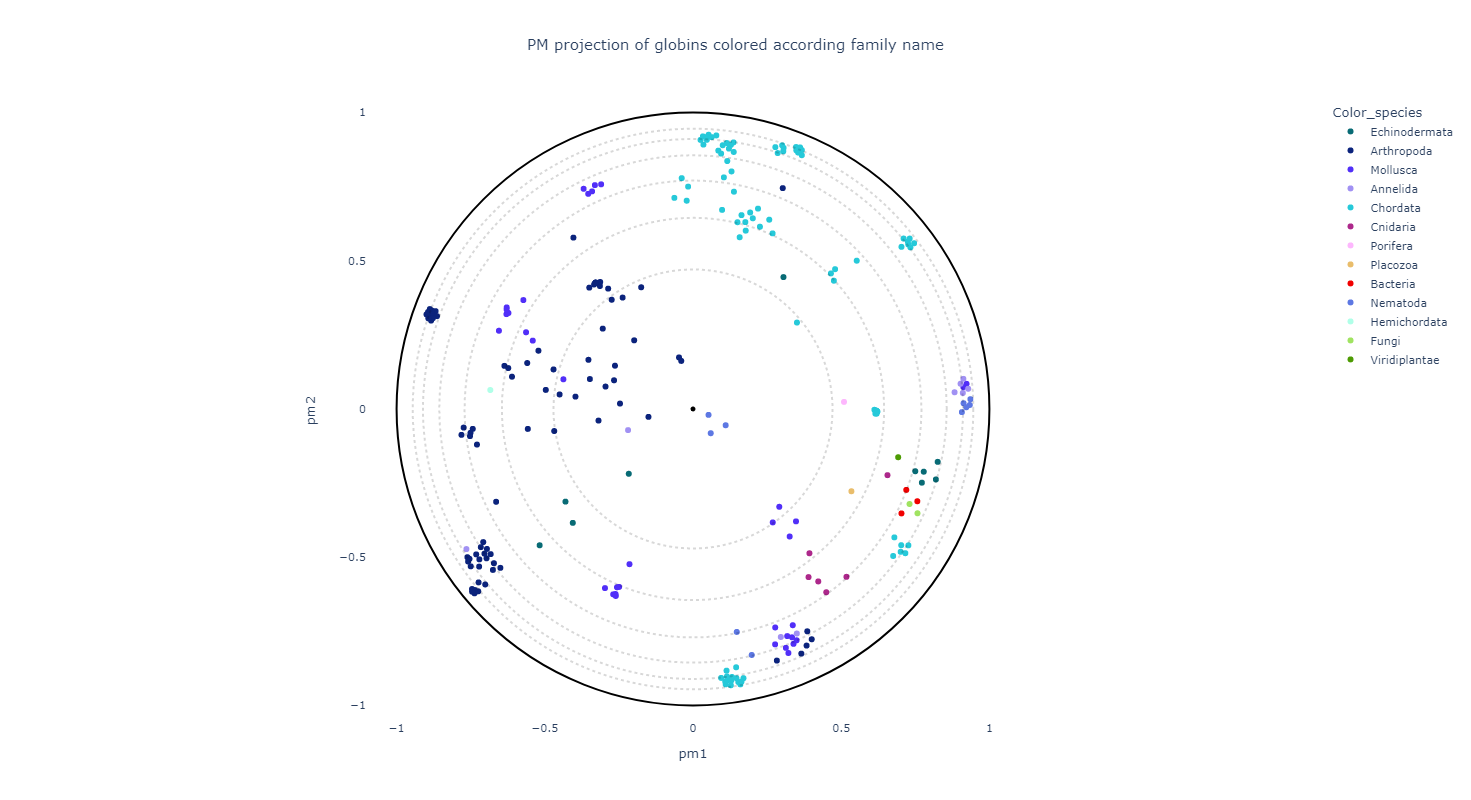

In [ ]:
# OPTIONS =================================================
#Here you can set different parameters to color & annotate the resulting projection:
title = "PM projection of globins colored according family name"
#----------------------------------------------------------
# Select the coloring from annotation .csv file:
labels_name = "Color_species"
# Select classes to label among the "labels_name" or "second_labels_name" column (comma separated list):
second_labels_name = ""
labels_text = []
show_text = False
#----------------------------------------------------------
# Use a custom color palette:
color_palette = globin_palette #Default: None
use_custom_palette = True
#==========================================================


#Check projection visualization parameters
#Labels name
if labels_name == "":
    labels_name = None
elif labels_name not in annotation_names:
    raise NameError(f"labels_name {labels_name} is not in the availables annotations.\nAvailables annotations: {annotation_names}")
#Second labels name
if second_labels_name == "":
    second_labels_name = None
elif second_labels_name not in annotation_names:
    raise NameError(f'"second_labels_name" {second_labels_name} is not in the availables annotations.\nAvailables annotations: {annotation_names}')

if not use_custom_palette:
    color_palette = None

#Plot graph
fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = labels_name,
                                 second_labels_name = second_labels_name, 
                                 show_text = show_text,
                                 labels_text = labels_text,
                                 color_palette = color_palette, 
                                 title = title, 
                                 fontsize = 11)
fig.show()

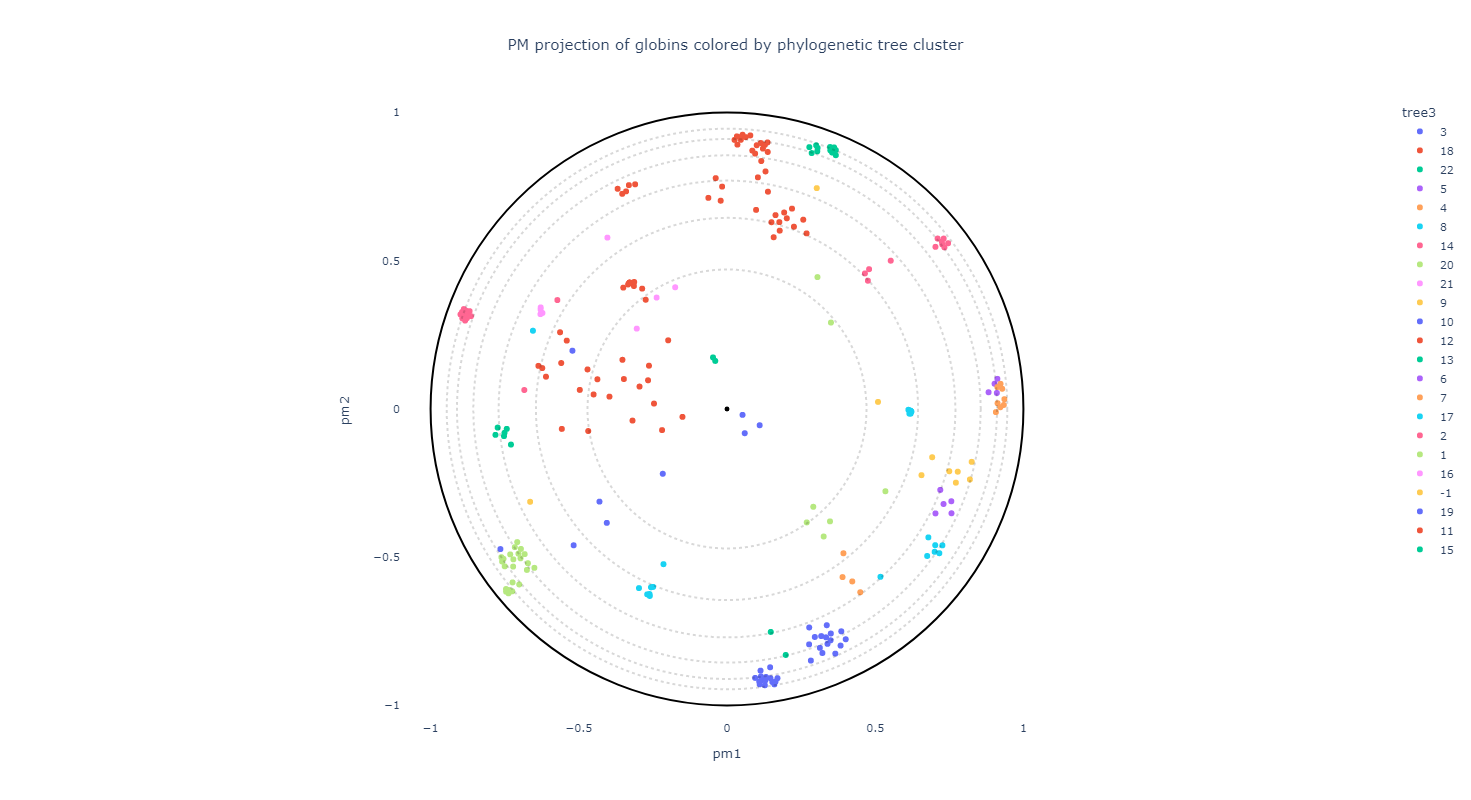

In [ ]:
# OPTIONS =================================================
#Here you can set different parameters to color & annotate the resulting projection:
title = "PM projection of globins colored by phylogenetic tree cluster"
#----------------------------------------------------------
# Select the coloring from annotation .csv file:
labels_name = "tree3"
# Select classes to label among the "labels_name" or "second_labels_name" column (comma separated list):
second_labels_name = ""
labels_text = []
show_text = False
#----------------------------------------------------------
# Use a custom color palette:
color_palette = None #Default: None
use_custom_palette = False
#==========================================================


#Check projection visualization parameters
#Labels name
if labels_name == "":
    labels_name = None
elif labels_name not in annotation_names:
    raise NameError(f"labels_name {labels_name} is not in the availables annotations.\nAvailables annotations: {annotation_names}")
#Second labels name
if second_labels_name == "":
    second_labels_name = None
elif second_labels_name not in annotation_names:
    raise NameError(f'"second_labels_name" {second_labels_name} is not in the availables annotations.\nAvailables annotations: {annotation_names}')

if not use_custom_palette:
    color_palette = None

#Plot graph
fig = plot_embedding_interactive(df_embedding, 
                                 labels_name = labels_name,
                                 second_labels_name = second_labels_name, 
                                 show_text = show_text,
                                 labels_text = labels_text,
                                 color_palette = color_palette, 
                                 title = title, 
                                 fontsize = 11)
fig.show()

### Save plot to file

In [ ]:
# OPTIONS =================================================
output_name = "fig1"
output_format = "png" #Format availables: ["png", "html", "pdf", "svg"]
#==========================================================


if output_format != "html":
    fig.write_image(f"{output_name}.{output_format}", engine="kaleido")
else:
    fig.write_html(f"{output_name}.{output_format}")